In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.plotly as py
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import warnings
# fuente original https://www.kaggle.com/mdolres/league-of-legends-2018-world-championiship/comments
warnings.filterwarnings('ignore')

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
init_notebook_mode(connected=True) 

data = pd.read_csv('worlds.csv', delimiter = ';')

#def comma_to_point(x):
#    return x.replace(',','.')
#data['gamelength'] = data['gamelength'].apply(comma_to_point).astype('float64')
#data['fttime'] = data['fttime'].apply(comma_to_point).astype('float64')
columns= data.columns
columns

Index(['gameid', 'url', 'league', 'split', 'date', 'week', 'game', 'patchno',
       'playerid', 'side', 'position', 'player', 'team', 'champion', 'ban1',
       'ban2', 'ban3', 'ban4', 'ban5', 'gamelength', 'result', 'k', 'd', 'a',
       'teamkills', 'teamdeaths', 'doubles', 'triples', 'quadras', 'pentas',
       'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd',
       'fdtime', 'teamdragkills', 'oppdragkills', 'elementals',
       'oppelementals', 'firedrakes', 'waterdrakes', 'earthdrakes',
       'airdrakes', 'elders', 'oppelders', 'herald', 'heraldtime', 'ft',
       'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
       'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare',
       'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm',
       'visionwards', 'visionwardbuys', 'visiblewardclearrate',
       'invisiblewardclearrate', 'totalgold', 'earnedg

In [5]:
data.head()

,gameid,url,league,split,date,week,game,patchno,playerid,side,...,gdat15,xpat10,oppxpat10,xpdat10,csat10,oppcsat10,csdat10,csat15,oppcsat15,csdat15
0,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,1,Blue,...,-798,4530,5051,-521,76,90,-14,116,122,-6
1,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,2,Blue,...,-1366,3679,3928,-249,60,64,-4,88,105,-17
2,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,3,Blue,...,-629,4751,4533,218,88,85,3,131,150,-19
3,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,4,Blue,...,-1829,3526,3532,-6,87,76,11,119,134,-15
4,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,5,Blue,...,-1156,2731,2376,355,4,3,1,6,5,1


In [6]:
player_names = data.player.unique()

# Initialize the Dataframe
players = pd.DataFrame(data[(data.player == 'Licorice')].mean())
players = players.transpose()
players.rename(index={0:'Licorice'}, inplace=True)

# Append each player
for player in player_names:
    if player != 'Team' and player != 'Licorice':
        p = pd.DataFrame((data[(data.player == player)].mean())).transpose()
        p.rename(index={0: player}, inplace=True)
        players = pd.concat([players, p], sort=False)
        
# Establish players mean max min median might be useful later
player_mean = pd.DataFrame(players.mean()).transpose()
player_max = pd.DataFrame(players.max()).transpose()
player_min = pd.DataFrame(players.min()).transpose()
player_median = pd.DataFrame(players.median()).transpose()

# Wards, dmg, KDA, Kill participation
# Gold diff at 15, Total damage, Gold spread
labels = ['wards','dmgtochamps','totalgold','k','d','a','gdat15']

# update player positions as they had been lost
players.insert(len(players.columns), column='position',value='ADC')
players.insert(len(players.columns), column='team',value='Cloud9')
for player in player_names:
    if player != 'Team':
        players.loc[player, 'position'] = data[data.player == player].position.values[0]
        players.loc[player, 'team'] = data[data.player == player].team.values[0]


team_names = data.team.unique()
teams = pd.DataFrame(data[(data.player == 'Team') & (data.team == 'Cloud9')].mean())
teams = teams.transpose()
teams.rename(index={0:'Cloud9'}, inplace=True)

for team in team_names:
    if team != 'Cloud9':
        p = pd.DataFrame((data[(data.team == team) & (data.player == 'Team')].mean())).transpose()
        p.rename(index={0: team}, inplace=True)
        teams = pd.concat([teams, p], sort=False)

In [7]:
# Used for data visualization later
def simple_radar_graph(player_name, color='blue', players=players, role='ADC'):
    x = pd.DataFrame(players.loc[player_name, labels]).transpose()
    player_max = pd.DataFrame(players[player.position == role].max()).transpose()
    
    data = [go.Scatterpolar(
      r = [(x['wards'].values[0] / player_max['wards'].values[0]) * 100,(x['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x['k'].values[0] / player_max['k'].values[0]),100 * (x['d'].values[0] / player_max['d'].values[0]),100 * (x['a'].values[0] / player_max['a'].values[0]),100 * (x["gdat15"].values[0] / player_max['gdat15'].values[0]), 100 * (x["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color
            )
    )]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      showlegend = False,
      title = "{}".format(player_name)
    )
    fig = go.Figure(data=data, layout=layout)
    

    return iplot(fig, filename = "Radar")

# used for data visualization later
def vs_radar_graph(player_name1, player_name2, color1='orange', color2='lightgray',title=None, players=players,role='ADC'):
    player_max = pd.DataFrame(players[players.position == role].max()).transpose()
    
    if not title:
         title='{} vs {}'.format(player_name1, player_name2)
    
    x1 = pd.DataFrame(players.loc[player_name1, labels]).transpose()
    x2 = pd.DataFrame(players.loc[player_name2, labels]).transpose()
    # MEDIAN : x3 = pd.DataFrame(players[players.position == role].median()).transpose()
    
    """
        MEDIAN
        go.Scatterpolar(
      name = player_name2,
      r = [(x3['wards'].values[0] / player_max['wards'].values[0]) * 100,(x3['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x3['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x3['k'].values[0] / player_max['k'].values[0]),100 * (x3['d'].values[0] / player_max['d'].values[0]),100 * (x3['a'].values[0] / player_max['a'].values[0]),100 * (x3["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Wards'],
      fill = 'toself',
         line =  dict(
                color = 'black'
            )
        ),
        
    add as 1st element in array below if you want
    """
    
    data = [go.Scatterpolar(
      name = player_name1,
      r = [(x1['wards'].values[0] / player_max['wards'].values[0]) * 100,(x1['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x1['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x1['k'].values[0] / player_max['k'].values[0]),100 * (x1['d'].values[0] / player_max['d'].values[0]),100 * (x1['a'].values[0] / player_max['a'].values[0]),100 * (x1["gdat15"].values[0] / player_max['gdat15'].values[0]),100 * (x1["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color1
            )
    ),
           
    go.Scatterpolar(
      name = player_name2,
      r = [(x2['wards'].values[0] / player_max['wards'].values[0]) * 100,(x2['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x2['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x2['k'].values[0] / player_max['k'].values[0]),100 * (x2['d'].values[0] / player_max['d'].values[0]),100 * (x2['a'].values[0] / player_max['a'].values[0]),100 * (x2["gdat15"].values[0] / player_max['gdat15'].values[0]),100 * (x2["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color2
            )
    )
           
    ]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      showlegend = False,
      title = "{}".format(title)
    )
    fig = go.Figure(data=data, layout=layout)
    

    return iplot(fig, filename = "Radar")

teams_labels = ['fb','gamelength', 'k', 'd', 'dmgtochamps','totalgold','fbaron','herald','ft','firstmidouter','firsttothreetowers','gdat15']
# used for data visualization later
def teamvs_radar_graph(team_name1, team_name2, color1='orange', color2='lightgray',title=None, teams=teams):
    team_max = pd.DataFrame(teams.max()).transpose()
    
    if not title:
         title='{} vs {}'.format(team_name1, team_name2)
    
    x1 = pd.DataFrame(teams.loc[team_name1, teams_labels]).transpose()
    x2 = pd.DataFrame(teams.loc[team_name2, teams_labels]).transpose()

    data = [go.Scatterpolar(
      name = team_name1,
      r = [(x1['fb'].values[0] / team_max['fb'].values[0]) * 100,(x1['gamelength'].values[0] / team_max['gamelength'].values[0]) * 100,(x1['k'].values[0] / team_max['k'].values[0]) * 100,(x1['d'].values[0] / team_max['d'].values[0]) * 100,(x1['dmgtochamps'].values[0] / team_max['dmgtochamps'].values[0]) * 100,100 * (x1['totalgold'].values[0] / team_max['totalgold'].values[0]),100 * (x1['fbaron'].values[0] / team_max['fbaron'].values[0]),100 * (x1['herald'].values[0] / team_max['herald'].values[0]),100 * (x1['ft'].values[0] / team_max['ft'].values[0]),100 * (x1["firstmidouter"].values[0] / team_max['firstmidouter'].values[0]),100 * (x1["firsttothreetowers"].values[0] / team_max['firsttothreetowers'].values[0]),100 * (x1["gdat15"].values[0] / team_max['gdat15'].values[0]),100 * (x1["fb"].values[0] / team_max['fb'].values[0])],
      theta =['First Blood', 'Game length', 'Kills', 'Deaths', 'Damages to champs','Total gold','First Baron','Herald','First tower','First mid outer tower','First to three towers','Gold difference at 15', 'First Blood'],
      fill = 'toself',
         line =  dict(
                color = color1
            )
    ),
           
    go.Scatterpolar(
      name = team_name2,
      r = [(x2['fb'].values[0] / team_max['fb'].values[0]) * 100,(x2['gamelength'].values[0] / team_max['gamelength'].values[0]) * 100,(x2['k'].values[0] / team_max['k'].values[0]) * 100, (x2['d'].values[0] / team_max['d'].values[0]) * 100,(x2['dmgtochamps'].values[0] / team_max['dmgtochamps'].values[0]) * 100,100 * (x2['totalgold'].values[0] / team_max['totalgold'].values[0]),100 * (x2['fbaron'].values[0] / team_max['fbaron'].values[0]),100 * (x2['herald'].values[0] / team_max['herald'].values[0]),100 * (x2['ft'].values[0] / team_max['ft'].values[0]),100 * (x2["firstmidouter"].values[0] / team_max['firstmidouter'].values[0]),100 * (x2["firsttothreetowers"].values[0] / team_max['firsttothreetowers'].values[0]),100 * (x2["gdat15"].values[0] / team_max['gdat15'].values[0]),100 * (x2["fb"].values[0] / team_max['fb'].values[0])],
      theta =['First Blood', 'Game length', 'Kills', 'Deaths', 'Damages to champs','Total gold','First Baron','Herald','First tower','First mid outer tower','First to three towers','Gold difference at 15', 'First Blood'],
      fill = 'toself',
         line =  dict(
                color = color2
            )
    )
           
    ]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      showlegend = False,
      title = "{}".format(title)
    )
    fig = go.Figure(data=data, layout=layout)
    

    return iplot(fig, filename = "Radar")

In [8]:
# Used for data visualization later
def simple_radar_graph(player_name, color='blue', players=players, role='ADC'):
    x = pd.DataFrame(players.loc[player_name, labels]).transpose()
    player_max = pd.DataFrame(players[player.position == role].max()).transpose()
    
    data = [go.Scatterpolar(
      r = [(x['wards'].values[0] / player_max['wards'].values[0]) * 100,(x['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x['k'].values[0] / player_max['k'].values[0]),100 * (x['d'].values[0] / player_max['d'].values[0]),100 * (x['a'].values[0] / player_max['a'].values[0]),100 * (x["gdat15"].values[0] / player_max['gdat15'].values[0]), 100 * (x["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color
            )
    )]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      showlegend = False,
      title = "{}".format(player_name)
    )
    fig = go.Figure(data=data, layout=layout)
    

    return iplot(fig, filename = "Radar")

# used for data visualization later
def vs_radar_graph(player_name1, player_name2, color1='orange', color2='lightgray',title=None, players=players,role='ADC'):
    player_max = pd.DataFrame(players[players.position == role].max()).transpose()
    
    if not title:
         title='{} vs {}'.format(player_name1, player_name2)
    
    x1 = pd.DataFrame(players.loc[player_name1, labels]).transpose()
    x2 = pd.DataFrame(players.loc[player_name2, labels]).transpose()
    # MEDIAN : x3 = pd.DataFrame(players[players.position == role].median()).transpose()
    
    """
        MEDIAN
        go.Scatterpolar(
      name = player_name2,
      r = [(x3['wards'].values[0] / player_max['wards'].values[0]) * 100,(x3['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x3['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x3['k'].values[0] / player_max['k'].values[0]),100 * (x3['d'].values[0] / player_max['d'].values[0]),100 * (x3['a'].values[0] / player_max['a'].values[0]),100 * (x3["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Wards'],
      fill = 'toself',
         line =  dict(
                color = 'black'
            )
        ),
        
    add as 1st element in array below if you want
    """
    
    data = [go.Scatterpolar(
      name = player_name1,
      r = [(x1['wards'].values[0] / player_max['wards'].values[0]) * 100,(x1['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x1['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x1['k'].values[0] / player_max['k'].values[0]),100 * (x1['d'].values[0] / player_max['d'].values[0]),100 * (x1['a'].values[0] / player_max['a'].values[0]),100 * (x1["gdat15"].values[0] / player_max['gdat15'].values[0]),100 * (x1["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color1
            )
    ),
           
    go.Scatterpolar(
      name = player_name2,
      r = [(x2['wards'].values[0] / player_max['wards'].values[0]) * 100,(x2['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x2['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x2['k'].values[0] / player_max['k'].values[0]),100 * (x2['d'].values[0] / player_max['d'].values[0]),100 * (x2['a'].values[0] / player_max['a'].values[0]),100 * (x2["gdat15"].values[0] / player_max['gdat15'].values[0]),100 * (x2["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color2
            )
    )
           
    ]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      showlegend = False,
      title = "{}".format(title)
    )
    fig = go.Figure(data=data, layout=layout)
    

    return iplot(fig, filename = "Radar")

teams_labels = ['fb','gamelength', 'k', 'd', 'dmgtochamps','totalgold','fbaron','herald','ft','firstmidouter','firsttothreetowers','gdat15']
# used for data visualization later
def teamvs_radar_graph(team_name1, team_name2, color1='orange', color2='lightgray',title=None, teams=teams):
    team_max = pd.DataFrame(teams.max()).transpose()
    
    if not title:
         title='{} vs {}'.format(team_name1, team_name2)
    
    x1 = pd.DataFrame(teams.loc[team_name1, teams_labels]).transpose()
    x2 = pd.DataFrame(teams.loc[team_name2, teams_labels]).transpose()

    data = [go.Scatterpolar(
      name = team_name1,
      r = [(x1['fb'].values[0] / team_max['fb'].values[0]) * 100,(x1['gamelength'].values[0] / team_max['gamelength'].values[0]) * 100,(x1['k'].values[0] / team_max['k'].values[0]) * 100,(x1['d'].values[0] / team_max['d'].values[0]) * 100,(x1['dmgtochamps'].values[0] / team_max['dmgtochamps'].values[0]) * 100,100 * (x1['totalgold'].values[0] / team_max['totalgold'].values[0]),100 * (x1['fbaron'].values[0] / team_max['fbaron'].values[0]),100 * (x1['herald'].values[0] / team_max['herald'].values[0]),100 * (x1['ft'].values[0] / team_max['ft'].values[0]),100 * (x1["firstmidouter"].values[0] / team_max['firstmidouter'].values[0]),100 * (x1["firsttothreetowers"].values[0] / team_max['firsttothreetowers'].values[0]),100 * (x1["gdat15"].values[0] / team_max['gdat15'].values[0]),100 * (x1["fb"].values[0] / team_max['fb'].values[0])],
      theta =['First Blood', 'Game length', 'Kills', 'Deaths', 'Damages to champs','Total gold','First Baron','Herald','First tower','First mid outer tower','First to three towers','Gold difference at 15', 'First Blood'],
      fill = 'toself',
         line =  dict(
                color = color1
            )
    ),
           
    go.Scatterpolar(
      name = team_name2,
      r = [(x2['fb'].values[0] / team_max['fb'].values[0]) * 100,(x2['gamelength'].values[0] / team_max['gamelength'].values[0]) * 100,(x2['k'].values[0] / team_max['k'].values[0]) * 100, (x2['d'].values[0] / team_max['d'].values[0]) * 100,(x2['dmgtochamps'].values[0] / team_max['dmgtochamps'].values[0]) * 100,100 * (x2['totalgold'].values[0] / team_max['totalgold'].values[0]),100 * (x2['fbaron'].values[0] / team_max['fbaron'].values[0]),100 * (x2['herald'].values[0] / team_max['herald'].values[0]),100 * (x2['ft'].values[0] / team_max['ft'].values[0]),100 * (x2["firstmidouter"].values[0] / team_max['firstmidouter'].values[0]),100 * (x2["firsttothreetowers"].values[0] / team_max['firsttothreetowers'].values[0]),100 * (x2["gdat15"].values[0] / team_max['gdat15'].values[0]),100 * (x2["fb"].values[0] / team_max['fb'].values[0])],
      theta =['First Blood', 'Game length', 'Kills', 'Deaths', 'Damages to champs','Total gold','First Baron','Herald','First tower','First mid outer tower','First to three towers','Gold difference at 15', 'First Blood'],
      fill = 'toself',
         line =  dict(
                color = color2
            )
    )
           
    ]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      showlegend = False,
      title = "{}".format(title)
    )
    fig = go.Figure(data=data, layout=layout)
    

    return iplot(fig, filename = "Radar")

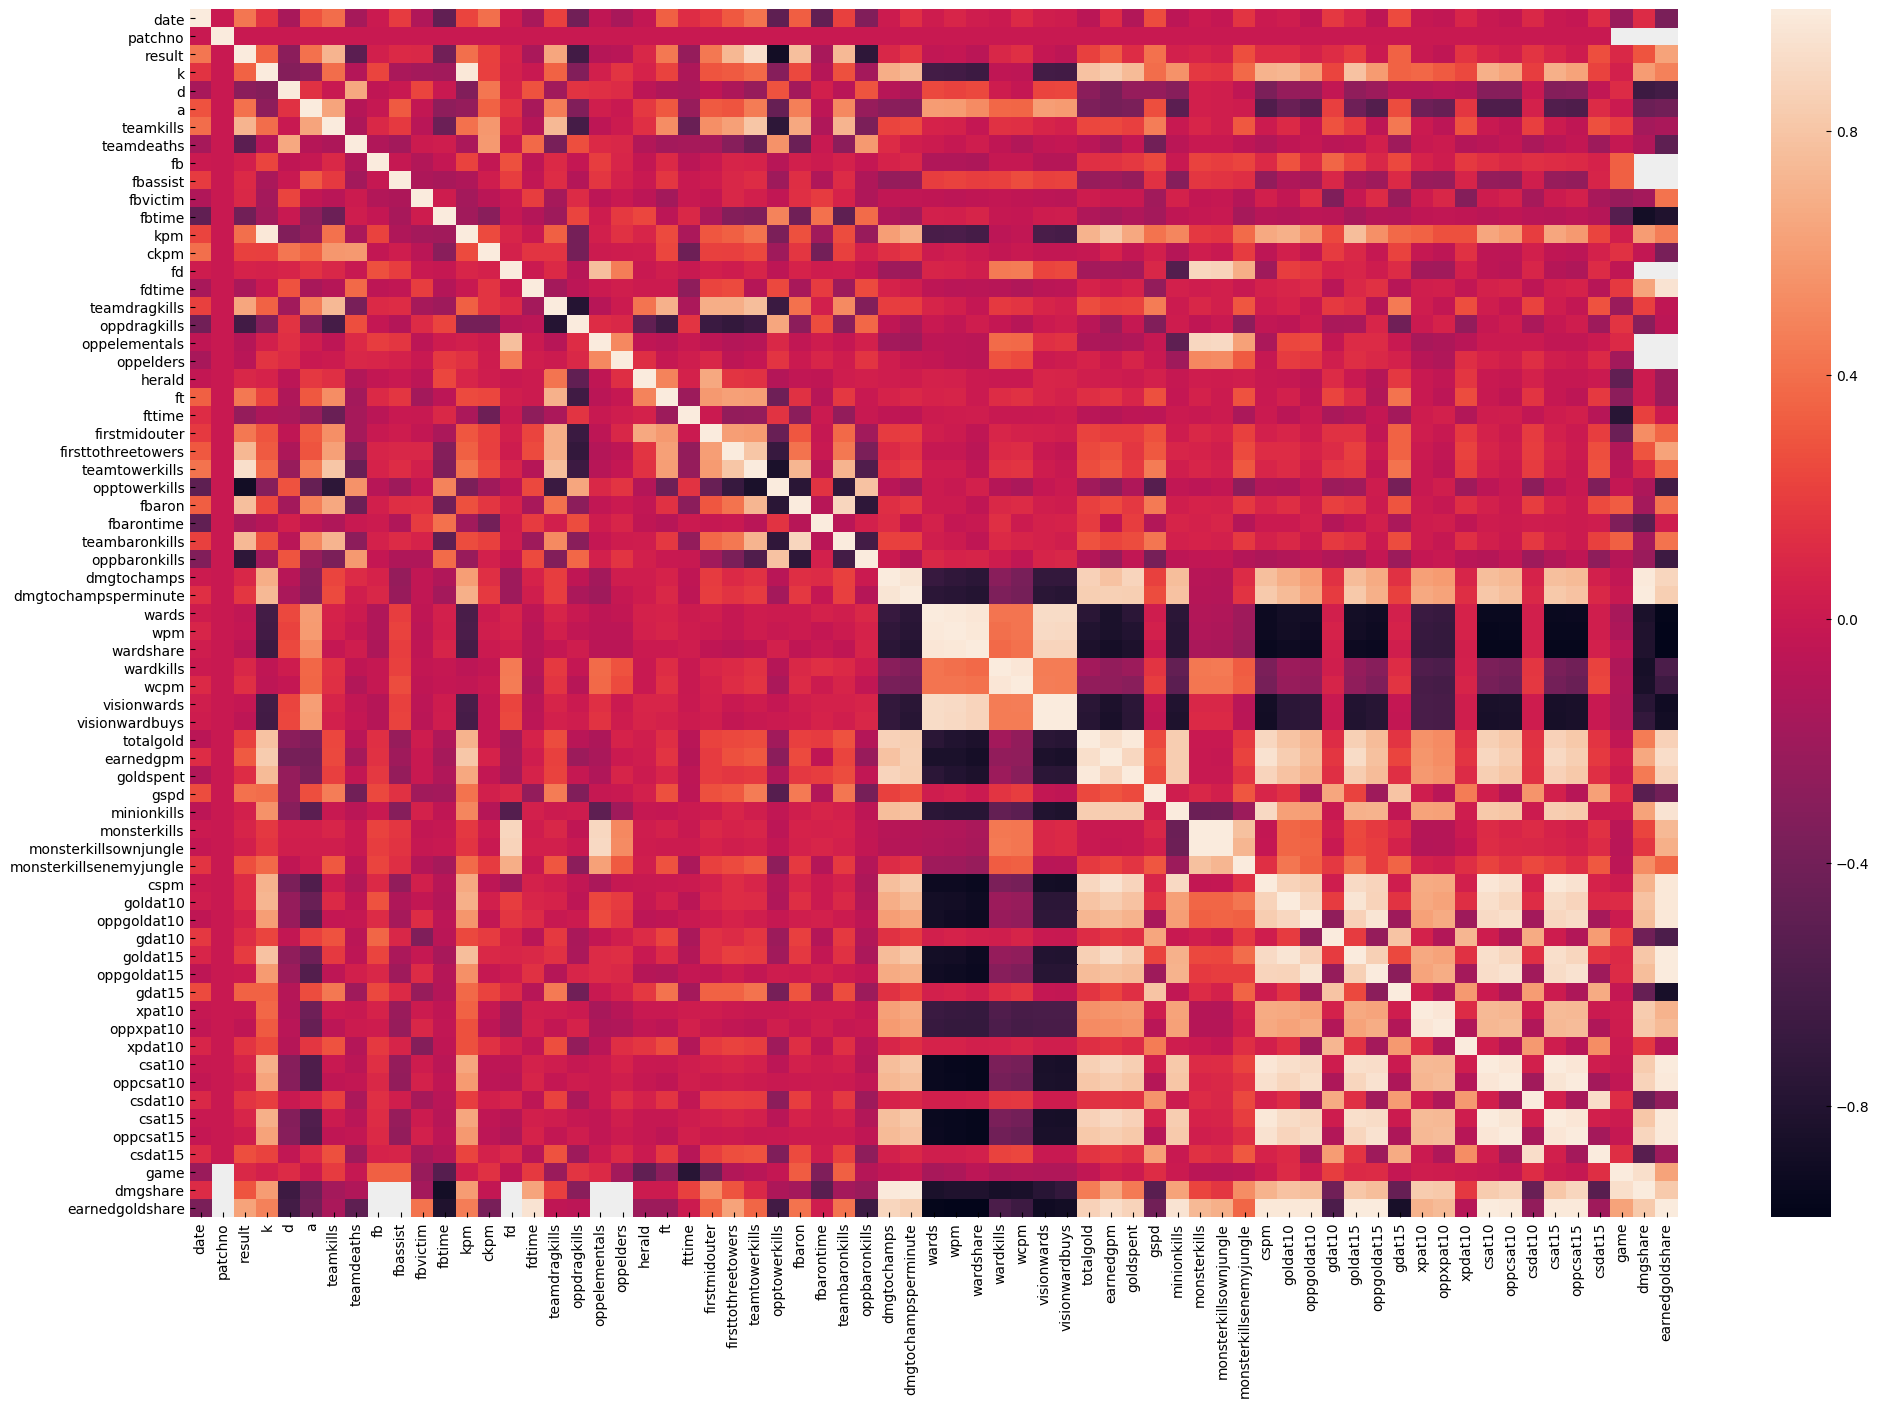

In [9]:
players_corr = players

# to avoid running the kernel everytime
if 'gameid' in players_corr.columns.tolist():
    # doubles/triples/quadras/pentas/okpm have suffered damages with the .mean() for unknown reasons,
    # elementals, airdrakes, ... are chosen with randomness so they're not significant
    # heraldtime barontime are not contained in players variables
    # time var : make no sense in corr
    players_corr = players_corr.drop(['doubles','triples','quadras','pentas','gameid','playerid','firedrakes','elders','elementals','waterdrakes','earthdrakes','airdrakes','heraldtime','okpm', 'gamelength'], axis=1)

corr = players_corr.corr()
f, ax = plt.subplots(figsize=(24, 16))
heatmap = sns.heatmap(corr)

## Top 10 most meaningful for winning stats

In [10]:
a = corr[corr != 1.0].max()
print('Top 10 most meaningful for winning stats')
i=0
while i <10:
    print(a.idxmax())
    a=a.drop(a.idxmax())
    i+=1


Top 10 most meaningful for winning stats
goldat15
earnedgoldshare
csat10
visionwards
visionwardbuys
csat15
oppcsat10
oppcsat15
oppgoldat15
dmgtochampsperminute


## Compare players or teams

In [11]:
vs_radar_graph('Crisp','Hylissang',color1='red', color2='orange', title='Support | (red) Crisp vs Hylissang (orange)', role='Support')

In [12]:
teamvs_radar_graph('Funplus Phoenix','Fnatic', color1='red', color2='orange',title='(red) Fun Plus Phoenix vs Fnatic (orange)', teams=teams)


In [13]:


team_name = 'G2 Esports'
print('{} average game length on win : {} minutes'.format(team_name,data[(data.player == 'Team') & (data.team == team_name) & (data.result == 1)]['gamelength'].mean()))
print('{} average game length on lose : {} minutes'.format(team_name,data[(data.player == 'Team') & (data.team == team_name) & (data.result == 0)]['gamelength'].mean()))

team_name = 'SK Telecom T1'
print('\n{} average game length on win : {} minutes'.format(team_name,data[(data.player == 'Team') & (data.team == team_name) & (data.result == 1)]['gamelength'].mean()))
print('{} average game length on lose : {} minutes'.format(team_name,data[(data.player == 'Team') & (data.team == team_name) & (data.result == 0)]['gamelength'].mean()))



G2 Esports average game length on win : 30.308333334999997 minutes
G2 Esports average game length on lose : 33.38888889 minutes

SK Telecom T1 average game length on win : 32.7166666675 minutes
SK Telecom T1 average game length on lose : 29.383333335 minutes


In [14]:


graph_data = data[(data.player != 'Team')]
print('Number of different champions overall : {}'.format(len(graph_data['champion'].unique())))



Number of different champions overall : 98


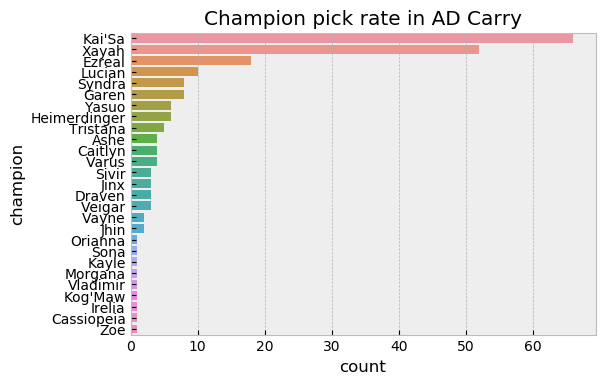

Number of different champions in AD Carry : 27


In [15]:


graph_data = data[(data.player != 'Team') & (data.position == 'ADC')]
sns.countplot(y="champion",data=graph_data, order=graph_data['champion'].value_counts().index)
plt.title('Champion pick rate in AD Carry')
plt.show()

print('Number of different champions in AD Carry : {}'.format(len(graph_data['champion'].unique())))



In [16]:
data.head()

,gameid,url,league,split,date,week,game,patchno,playerid,side,...,gdat15,xpat10,oppxpat10,xpdat10,csat10,oppcsat10,csdat10,csat15,oppcsat15,csdat15
0,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,1,Blue,...,-798,4530,5051,-521,76,90,-14,116,122,-6
1,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,2,Blue,...,-1366,3679,3928,-249,60,64,-4,88,105,-17
2,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,3,Blue,...,-629,4751,4533,218,88,85,3,131,150,-19
3,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,4,Blue,...,-1829,3526,3532,-6,87,76,11,119,134,-15
4,1070340,https://matchhistory.euw.leagueoflegends.com/e...,WC,2019-W,43740.28615,PI-RR,1,9.19,5,Blue,...,-1156,2731,2376,355,4,3,1,6,5,1


In [17]:
columns

Index(['gameid', 'url', 'league', 'split', 'date', 'week', 'game', 'patchno',
       'playerid', 'side', 'position', 'player', 'team', 'champion', 'ban1',
       'ban2', 'ban3', 'ban4', 'ban5', 'gamelength', 'result', 'k', 'd', 'a',
       'teamkills', 'teamdeaths', 'doubles', 'triples', 'quadras', 'pentas',
       'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd',
       'fdtime', 'teamdragkills', 'oppdragkills', 'elementals',
       'oppelementals', 'firedrakes', 'waterdrakes', 'earthdrakes',
       'airdrakes', 'elders', 'oppelders', 'herald', 'heraldtime', 'ft',
       'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
       'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare',
       'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm',
       'visionwards', 'visionwardbuys', 'visiblewardclearrate',
       'invisiblewardclearrate', 'totalgold', 'earnedg

In [18]:
champion_names = data.champion.unique()
champions = pd.DataFrame(data[(data.champion == 'Gnar')].mean())
champions = champions.transpose()
champions.rename(index={0:'Gnar'}, inplace=True)
champion_app = data['champion']
for champion in champion_names:
    if champion !=  'Gnar':
        p = pd.DataFrame((data[(data.champion == champion)].mean())).transpose()
        p.rename(index={0: champion}, inplace=True)
        champions = pd.concat([champions, p], sort=False)

        
champions['Played'] = champion_app.value_counts()        
champions_mean = pd.DataFrame(champions.mean()).transpose()
champions_max = pd.DataFrame(champions.max()).transpose()
champions_min = pd.DataFrame(champions.min()).transpose()
champions_median = pd.DataFrame(champions.median()).transpose()

# Wards, dmg, KDA, Kill participation
# Gold diff at 15, Total damage, Gold spread
labels = ['wards','dmgtochamps','totalgold','k','d','a','gdat15']

# update player positions as they had been lost
champions.insert(len(champions.columns), column='position',value='ADC')
champions.insert(len(champions.columns), column='team',value='Cloud9')
for champion in champion_names:
    if champion != 'Team':
        champions.loc[champion, 'position'] = data[data.champion == champion].position.values[0]
        champions.loc[champion, 'team'] = data[data.champion == champion].team.values[0]



In [19]:
champions.columns

Index(['gameid', 'date', 'patchno', 'playerid', 'gamelength', 'result', 'k',
       'd', 'a', 'teamkills', 'teamdeaths', 'doubles', 'triples', 'quadras',
       'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm',
       'fd', 'fdtime', 'teamdragkills', 'oppdragkills', 'elementals',
       'oppelementals', 'firedrakes', 'waterdrakes', 'earthdrakes',
       'airdrakes', 'elders', 'oppelders', 'herald', 'heraldtime', 'ft',
       'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills',
       'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'wards', 'wpm',
       'wardshare', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys',
       'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills',
       'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle',
       'cspm', 'goldat10', 'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15',
       'gdat15', 'xpat10', 'oppxpat10',

## Clean some data! drop not meaningful rows or with NaN numbers and one invalid observation

In [20]:
champions =champions.drop(['gameid', 'date', 'patchno', 'playerid','doubles', 'triples', 'quadras','pentas','team','game', 'dmgshare', 'earnedgoldshare'], axis=1)
champions= champions[champions.position != 'Team']

## Show champions played more than 3 times ordered by a certain variable

In [21]:
played_3 =  champions['Played']>=3
champions[played_3].sort_values(by=['goldat15'], ascending=False)


,gamelength,result,k,d,a,teamkills,teamdeaths,fb,fbassist,fbvictim,...,oppxpat10,xpdat10,csat10,oppcsat10,csdat10,csat15,oppcsat15,csdat15,Played,position
Varus,29.029167,1.000000,7.250000,0.750000,6.750000,19.000000,6.000000,0.250000,0.000000,0.000000,...,3118.750000,186.500000,88.000000,75.500000,12.500000,141.000000,124.000000,17.000000,4,ADC
Corki,35.343750,0.500000,2.625000,2.000000,3.750000,10.500000,13.125000,0.000000,0.125000,0.000000,...,4683.250000,18.875000,87.875000,89.250000,-1.375000,147.500000,144.375000,3.125000,8,Middle
Twisted Fate,31.260417,0.500000,1.250000,3.000000,4.250000,10.125000,14.750000,0.000000,0.125000,0.375000,...,4709.875000,-146.000000,83.375000,84.500000,-1.125000,130.125000,135.750000,-5.625000,8,Middle
Irelia,34.033333,0.375000,3.625000,3.750000,4.375000,13.500000,15.500000,0.375000,0.250000,0.000000,...,4278.750000,14.125000,83.750000,80.750000,3.000000,138.750000,128.125000,10.625000,8,Top
Veigar,31.313333,0.600000,3.600000,1.600000,6.600000,13.400000,11.600000,0.200000,0.000000,0.200000,...,3980.800000,-61.200000,84.400000,91.000000,-6.600000,131.200000,135.800000,-4.600000,5,ADC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rakan,33.468750,0.550000,0.525000,2.175000,9.300000,12.750000,10.975000,0.075000,0.175000,0.000000,...,2719.600000,-54.200000,2.275000,9.450000,-7.175000,5.600000,16.625000,-11.025000,40,Support
Thresh,33.181250,0.406250,0.843750,3.031250,7.968750,13.343750,14.375000,0.093750,0.093750,0.093750,...,2607.968750,97.718750,2.000000,9.593750,-7.593750,5.281250,16.343750,-11.062500,32,Support
Leona,35.150926,0.722222,0.611111,3.666667,8.388889,15.555556,11.944444,0.000000,0.166667,0.222222,...,2617.166667,-94.444444,14.222222,8.666667,5.555556,24.722222,16.000000,8.722222,18,Support
Nautilus,33.707576,0.522727,0.727273,3.250000,6.613636,12.818182,13.181818,0.022727,0.250000,0.113636,...,2646.409091,-26.590909,14.931818,7.454545,7.477273,25.386364,13.340909,12.045455,44,Support


## Function for comparing champions

In [22]:
def vs_champion_radar_graph(champion_name1, champion_name2, color1='orange', color2='lightgray',title=None, players=players,role='ADC'):
    champion_max = pd.DataFrame(champions[champions.position == role].max()).transpose()
    
    if not title:
         title='{} vs {}'.format(champion_name1, champion_name2)
    
    x1 = pd.DataFrame(champions.loc[champion_name1, labels]).transpose()
    x2 = pd.DataFrame(champions.loc[champion_name2, labels]).transpose()
    # MEDIAN : x3 = pd.DataFrame(players[players.position == role].median()).transpose()
    
    """
        MEDIAN
        go.Scatterpolar(
      name = player_name2,
      r = [(x3['wards'].values[0] / player_max['wards'].values[0]) * 100,(x3['dmgtochamps'].values[0] / player_max['dmgtochamps'].values[0]) * 100,100 * (x3['totalgold'].values[0] / player_max['totalgold'].values[0]),100 * (x3['k'].values[0] / player_max['k'].values[0]),100 * (x3['d'].values[0] / player_max['d'].values[0]),100 * (x3['a'].values[0] / player_max['a'].values[0]),100 * (x3["wards"].values[0] / player_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Wards'],
      fill = 'toself',
         line =  dict(
                color = 'black'
            )
        ),
        
    add as 1st element in array below if you want
    """
    
    data = [go.Scatterpolar(
      name = champion_name1,
      r = [(x1['wards'].values[0] / champion_max['wards'].values[0]) * 100,(x1['dmgtochamps'].values[0] / champion_max['dmgtochamps'].values[0]) * 100,100 * (x1['totalgold'].values[0] / champion_max['totalgold'].values[0]),100 * (x1['k'].values[0] / champion_max['k'].values[0]),100 * (x1['d'].values[0] / champion_max['d'].values[0]),100 * (x1['a'].values[0] / champion_max['a'].values[0]),100 * (x1["gdat15"].values[0] / champion_max['gdat15'].values[0]),100 * (x1["wards"].values[0] / champion_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color1
            )
    ),
           
    go.Scatterpolar(
      name = champion_name2,
      r = [(x2['wards'].values[0] / champion_max['wards'].values[0]) * 100,(x2['dmgtochamps'].values[0] / champion_max['dmgtochamps'].values[0]) * 100,100 * (x2['totalgold'].values[0] / champion_max['totalgold'].values[0]),100 * (x2['k'].values[0] / champion_max['k'].values[0]),100 * (x2['d'].values[0] / champion_max['d'].values[0]),100 * (x2['a'].values[0] / champion_max['a'].values[0]),100 * (x2["gdat15"].values[0] / champion_max['gdat15'].values[0]),100 * (x2["wards"].values[0] / champion_max['wards'].values[0])],
      theta = ['Wards','Damages to champs', 'Total gold','Kills','Deaths','Assists','Opponent gold difference at 15m','Wards'],
      fill = 'toself',
         line =  dict(
                color = color2
            )
    )
           
    ]

    layout = go.Layout(
      polar = dict(
        radialaxis = dict(
          visible = True,
          range = [0, 100]
        )
      ),
      showlegend = False,
      title = "{}".format(title)
    )
    fig = go.Figure(data=data, layout=layout)
    

    return iplot(fig, filename = "Radar")


In [23]:
vs_champion_radar_graph('Xayah',"Kai'Sa", color1='orange', color2='lightgray',role='ADC')
vs_champion_radar_graph('Ezreal',"Lucian", color1='blue', color2='black',role='ADC')
vs_champion_radar_graph('Syndra',"Garen", color1='red', color2='green',role='ADC')
